In [8]:
import numpy as np
import glob
import random
from scipy import sparse

from tools.text_process import LemmaTokenizer
from tools.image_process import getLayerNames, checkLayerNames, image2feature
from models.vectorizer import getVectorizer

# Similarity between category keywords and the description
# suppress cats not in image??**
from tools.image_process import image2SimiFeature

# random image generator, subject to rules
from tools.generator import ranGenLayer

class Dataset():
    def __init__(self, img_dir='images', txt_dir='text'):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.tokenizer = LemmaTokenizer()
        # this operation will process all the text and train a vectorizer
        # so we have double processed the text here
        self.vectorizer = getVectorizer()
        
        # set features
        self.__get_featureNames()
        
    def __getone(self, txt_name=None, img_name=None,
                       ran_txt=False, ran_img=False,
                       fake_img=False):
        # preprocess
        ## text
        if ran_txt:
            all_txt = glob.glob(self.txt_dir+'/*.txt')
            # rule out current text
            all_txt.remove(txt_name)
            txt_name = random.choice(all_txt)
        else:
            assert(txt_name)
            
        with open(txt_name, 'r') as f:
            orig_sent = f.read()
            sent = self.tokenizer(orig_sent)
            
        ## image
        if ran_img:
            assert img_name
            assert not fake_img
            all_img = glob.glob(self.img_dir+'/*.svg')
            all_img.remove(img_name)
            img_name = random.choice(all_img)
            layers = getLayerNames(img_name)
        elif fake_img:
            assert img_name is None
            assert not ran_img
            layers = ranGenLayer()
        else:
            layers = getLayerNames(img_name)
        
        # tofeature
        txt_embed = self.vectorizer.transform([sent]).toarray()[0]
        img_embed = image2feature(layers)
        joint_embed = image2SimiFeature(layers, sent)
        
        return np.hstack([txt_embed, img_embed, joint_embed])        
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        txt_name = '%s/%i.txt' % (self.txt_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.__getone(txt_name=txt_name, img_name=img_name))
        # fake image
        triplets.append(self.__getone(txt_name=txt_name, fake_img=True))
        # mismatched text
        triplets.append(self.__getone(img_name=img_name, txt_name=txt_name, ran_txt=True))
        # mismatched image
        triplets.append(self.__getone(img_name=img_name, txt_name=txt_name, ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        ys = np.array([1,0,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))

    
    def __len__(self):
        return len(glob.glob(self.img_dir+'/*.svg'))
    
    def __get_featureNames(self):
        self.features_ = []
        # text features
        txt_names, _ = zip(*sorted(self.vectorizer.vocabulary_.items(), 
                                   key=lambda x:x[::-1]))
        self.features_.extend(list(txt_names))

        # image features
        from tools.image_process import getNestedKey
        from rules.category import surrouding_dict, person_dict
        self.features_.append('_NLayers_')
        self.features_.extend(['_Background_',
                               '_Surroundings_',
                               '_Person_',
                               '_Decoration_'])
        srd_keys = getNestedKey(surrouding_dict)
        prs_keys = getNestedKey(person_dict)
        self.features_.extend(['_S_%s_' % k for k in srd_keys])
        self.features_.extend(['_P_%s_' % k for k in prs_keys])

        # joint features
        self.features_.extend(['_simi_S_%s_' % k for k in srd_keys])
        self.features_.extend(['_simi_P_%s_' % k for k in prs_keys])

In [9]:
from sklearn.linear_model import LogisticRegression
dataset = Dataset()
print('# features: ', len(dataset.features_))
data = sparse.vstack([dataset[i] for i in range(len(dataset))])
X, y = data[:,:-1], data[:,-1]
y = y.toarray().flatten()
print('data shape', data.shape)


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: "sideways" does not belong to any synsets.
  warnings.warn('"%s" does not belong to any synsets.' % lemma)
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: "grid" does not belong to any synsets.
  warnings.warn('"%s" does not belong to any synsets.' % lemma)


# features:  174


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: "sideways" does not belong to any synsets.
  warnings.warn('"%s" does not belong to any synsets.' % lemma)
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: "grid" does not belong to any synsets.
  warnings.warn('"%s" does not belong to any synsets.' % lemma)


data shape (80, 175)


In [10]:
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         # class_weight={1: 1, 0:0.5},
                         penalty='l2', #'l1' use l1 to learn sparsely
                         C=1.0,
                         max_iter=100)

clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
import matplotlib.pyplot as plt

Accuracy:  0.825


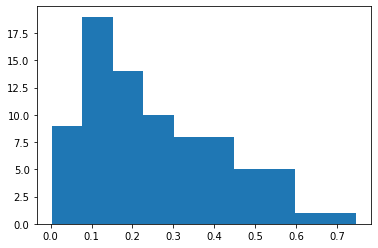

In [12]:
print('Accuracy: ', clf.score(X,y))
# print(clf.predict(X))
# print(clf.predict_proba(X)[:,1])
# print(y)
plt.hist(clf.predict_proba(X)[:,1])
plt.show()

In [13]:
d = dict(zip(dataset.features_, clf.coef_.tolist()[0]))
sorted(d.items(), key=lambda x: abs(x[1]))[::-1]

[('_simi_P_sit_', 0.9422245072191695),
 ('_simi_S_chart_', 0.9085721855441456),
 ('_simi_P_gesture_', 0.6623891371944062),
 ('_simi_S_appliance_', 0.6530216412676356),
 ('_simi_P_office_', 0.5722487763228143),
 ('_Background_', 0.5621338229455941),
 ('_simi_S_art_', 0.49767443201902223),
 ('_P_gesture_', 0.4632618392808044),
 ('_Decoration_', -0.4449544012269966),
 ('_simi_P_stand_', 0.4405876064179963),
 ('_Surroundings_', -0.4353057303561695),
 ('_simi_P_show_', 0.4262121957566661),
 ('_simi_S_city_', 0.42124069452434576),
 ('_simi_P_back_', 0.42120780014606535),
 ('_simi_S_vehicle_', -0.4192888225596022),
 ('_P_office_', 0.3477961560728519),
 ('_P_show_', -0.342535370492198),
 ('_S_chart_', -0.33009831732639205),
 ('_simi_P_travel_', -0.3088698264133972),
 ('_simi_P_family_', -0.2972312092597121),
 ('_simi_P_sport_', 0.2907955856058221),
 ('_simi_S_building_', 0.2761004547070339),
 ('_simi_S_nature_', 0.2746563746246816),
 ('chart.n.01', -0.27424398286777135),
 ('_P_stand_', -0.2522

In [7]:
# todo - unseen keywords